### Problem Statement

The NYC Open Data has an interesting dataset on the reported instances of graffiti across the city. In general my initial reaction to this dataset was why do we track it? Does it actually more closely reflect the people of NYC's tolerance for graffiti in their neighborhoods and could there actually be under reporting the true instances of graffiti. 

In general this is an exploration exercise to describe where we are seeing these instances reported. 

In [1]:
from __future__ import division, print_function
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import datetime as dt
import os
import io
import urllib
import geopandas as gpd
import json
import shapely
import pysal as ps
from fiona.crs import from_epsg
from shapely.geometry import LineString, Point
from geopandas.tools import sjoin
import choroplethNYC as cp
# In a notebook environment, display the plots inline
%matplotlib inline

In [2]:
# setting environmental variable
# uses the os lib
if os.getenv ("PUIDATA") is None:
    print ("Must set env variable PUI2018")
print(os.getenv("PUIDATA"))

/nfshome/yg833/PUIdata


### Download and Read in the Data
Using 3 different data sets:

1) Reported Instances of Graffiti in NYC: https://data.cityofnewyork.us/City-Government/DSNY-Graffiti-Tracking/gpwd-npar

2) Use the census tract: https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku


#### 1) NYC Graffiti

In [3]:
!curl https://data.cityofnewyork.us/api/views/gpwd-npar/rows.csv?accessType=DOWNLOAD > NYCgraffitiData.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  503k    0  503k    0     0  1407k      0 --:--:-- --:--:-- --:--:-- 1409k


In [4]:
# move the data
!mv NYCgraffitiData.csv $PUIDATA

In [5]:
graffitiDF = pd.read_csv("%s/NYCgraffitiData.csv"%os.getenv("PUIDATA")) # read in the data

##### Check the data

In [6]:
graffitiDF.head(5) # check the data

,INCIDENT_ADDRESS,BOROUGH,COMMUNITY_BOARD,POLICE_PRECINCT,CITY_COUNCIL_DISTRICT,BBL,CREATED_DATE,STATUS,RESOLUTION_ACTION,CLOSED_DATE,X_COORDINATE,Y_COORDINATE,LATITUDE,LONGITUDE,ZIP_CODE,CENSUS_TRACT,BIN,NTA,LOCATION
0,43 WEST 65 STREET,MANHATTAN,07 MANHATTAN,Precinct 20,6.0,1.011180e+09,03/11/2018,Open,Notice of Intent to Clean and Forever graffiti...,NaN,989655.0,220659.0,40.772333,-73.980486,10023.0,149.0,1028160.0,Lincoln Square,"(40.772333, -73.980486)"
1,1700 DITMAS AVENUE,BROOKLYN,14 BROOKLYN,Precinct 70,40.0,3.052030e+09,03/10/2018,Open,Notice of Intent to Clean and Forever graffiti...,NaN,994870.0,171715.0,40.637989,-73.961735,11226.0,518.0,3120202.0,Flatbush,"(40.637989, -73.961735)"
2,504 EAST 11 STREET,MANHATTAN,03 MANHATTAN,Precinct 9,2.0,1.004040e+09,03/09/2018,Open,Notice of Intent to Clean and Forever graffiti...,NaN,989410.0,204604.0,40.728266,-73.981383,10009.0,34.0,1076974.0,East Village,"(40.728266, -73.981383)"
3,494 MADISON STREET,BROOKLYN,03 BROOKLYN,Precinct 81,36.0,3.016440e+09,03/07/2018,Open,Notice of Intent to Clean and Forever graffiti...,NaN,1001445.0,189269.0,40.686160,-73.938000,11221.0,277.0,3045053.0,Stuyvesant Heights,"(40.68616, -73.938)"
4,1770 PITKIN AVENUE,BROOKLYN,16 BROOKLYN,Precinct 73,41.0,3.035250e+09,03/06/2018,Open,Notice of Intent to Clean and Forever graffiti...,NaN,1009832.0,183432.0,40.670119,-73.907781,11212.0,906.0,3348958.0,Brownsville,"(40.670119, -73.907781)"


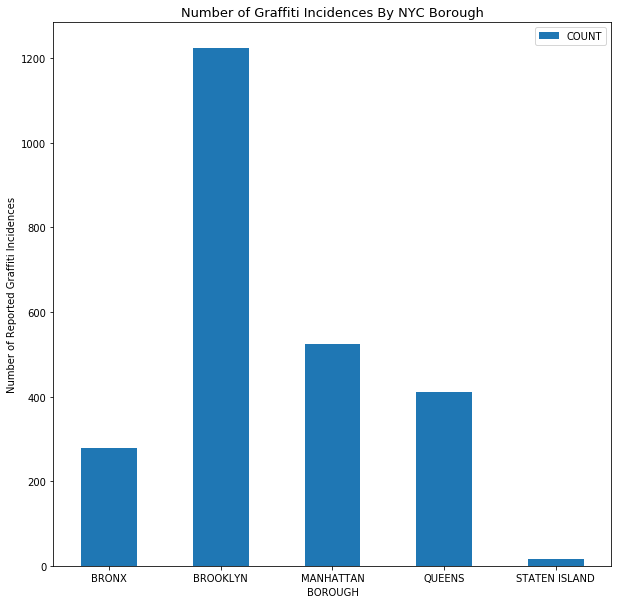

In [7]:
by_boro = graffitiDF[['BOROUGH']].groupby(['BOROUGH']).size().reset_index()
by_boro.columns = ['BOROUGH', 'COUNT']
by_boro.plot.bar(x= 'BOROUGH', y ='COUNT' , rot= 0, figsize = (10,10))
plt.ylabel('Number of Reported Graffiti Incidences')
plt.title('Number of Graffiti Incidences By NYC Borough', fontsize = 13);

### Figure 1:

Reported graffiti incidences by borough. Wanted to see which borough has the highest number of reported cases. It seems like its Brooklyn at over 2500 cases. 

In [8]:
# Count the number of incidences per location point
graffiti = pd.DataFrame(graffitiDF[['INCIDENT_ADDRESS', 'LOCATION', 'LATITUDE', 'LONGITUDE']].groupby(['INCIDENT_ADDRESS', 'LOCATION', 'LATITUDE', 'LONGITUDE']).size()).reset_index()

In [9]:
graffiti.columns = ['INCIDENT_ADDRESS', 'LOCATION', 'LATITUDE', 'LONGITUDE', 'count']

In [10]:
graffiti_geodf = gpd.GeoDataFrame(graffiti) # read it in as a geodataframe

In [11]:
# creating a lonlat and geometry column for plotting as a map later
graffiti_geodf['lonlat']=list(zip(graffiti_geodf.LONGITUDE,graffiti_geodf.LATITUDE))
graffiti_geodf['geometry'] = graffiti_geodf[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
graffiti_geodf.head(5)

,INCIDENT_ADDRESS,LOCATION,LATITUDE,LONGITUDE,count,lonlat,geometry
0,1 BRIGHTON 4 ROAD,"(40.582459, -73.964067)",40.582459,-73.964067,1,"(-73.964067, 40.582459)",POINT (-73.964067 40.582459)
1,1 CLINTON STREET,"(40.696162, -73.991363)",40.696162,-73.991363,1,"(-73.991363, 40.696162)",POINT (-73.99136300000001 40.696162)
2,1 COFFEY STREET,"(40.673731, -74.010469)",40.673731,-74.010469,1,"(-74.010469, 40.673731)",POINT (-74.010469 40.673731)
3,1 EAST 44 STREET,"(40.754687, -73.97969)",40.754687,-73.979690,1,"(-73.97969, 40.754687)",POINT (-73.97969000000001 40.754687)
4,10 COFFEY STREET,"(40.673877, -74.010653)",40.673877,-74.010653,1,"(-74.010653, 40.673877)",POINT (-74.010653 40.673877)


#### 2) Census Tract Shape File

In [12]:
## Use the census tract: https://data.cityofnewyork.us/City-Government/2010-Census-Tracts/fxpq-c8ku
url = "https://data.cityofnewyork.us/api/geospatial/fxpq-c8ku?method=export&format=Shapefile"
file = "nyc_ct" #nyc census tract

def getUnzipNYC(url, file):
    '''
    takes the arguments of an url and a file/ folder name
    opens it, downloads, moves it to the PUIData folder, and unzips the folder
    '''
    if os.path.isdir(os.getenv("PUIDATA") +'/'+ file) == True and len(os.listdir(os.getenv("PUIDATA") +'/'+ file + '/')) > 4:
        print("files are in place, good to go")
    else:
        if os.path.isfile(os.getenv("PUIDATA") +'/'+ file +'.gz') == True and len(os.listdir(os.getenv("PUIDATA") +'/'+ file)) < 4:
            print("file is downloaded but need to be unzipped")
            #makes a directory for the unzip file folder
            os.system("mkdir "+ os.getenv("PUIDATA")+ "/" +file)
            #!unzip file to PUIDATA folder
            os.system("unzip -d " + os.getenv("PUIDATA")+ "/" + file + " "+os.getenv("PUIDATA")+ "/"+file+".gz")
        else:
            print("need to download, move, and unzip the files")
            # download the shape file as a zip folder
            urllib.request.urlretrieve(url, file+'.gz')
            # move the zip file to the PUIDATA folder
            os.system("mv " + file + ".gz " + os.getenv("PUIDATA"))
            #make the unzip folder
            os.system("mkdir "+ os.getenv("PUIDATA")+ "/" +file)
            # then unpack the data into your PUIdata directory, 
            os.system("unzip -d " + os.getenv("PUIDATA")+ "/" + file + " "+os.getenv("PUIDATA")+ "/"+file+".gz")
    
    # rename the files in the unzipped folder
    for item in (os.listdir(os.getenv("PUIDATA") +'/'+ file + '/')):
        path = (os.getenv("PUIDATA") +'/'+ file + '/')
        if item.endswith(".dbf"):
            os.rename(path + item, path + file + '.dbf')
        if item.endswith(".prj"):
            os.rename(path + item, path + file + '.prj')
        if item.endswith(".shp"):
            os.rename(path + item, path + file + '.shp')
        if item.endswith(".shx"):
            os.rename(path + item, path + file + '.shx')        

getUnzipNYC(url, file)

files are in place, good to go


In [13]:
ct = gpd.GeoDataFrame.from_file(os.getenv("PUIDATA") + '/' +file+'/'+ file +'.shp')

In [14]:
ct.head() # check the file

,boro_code,boro_ct201,boro_name,cdeligibil,ct2010,ctlabel,ntacode,ntaname,puma,shape_area,shape_leng,geometry
0,5,5000900,Staten Island,I,000900,9,SI22,West New Brighton-New Brighton-St. George,3903,2.497010e+06,7729.016794,POLYGON ((-74.07920577013245 40.64343078374567...
1,1,1009800,Manhattan,I,009800,98,MN19,Turtle Bay-East Midtown,3808,1.906016e+06,5534.199811,POLYGON ((-73.96432543478758 40.75638153099091...
2,1,1010000,Manhattan,I,010000,100,MN19,Turtle Bay-East Midtown,3808,1.860938e+06,5692.168737,POLYGON ((-73.96802436915851 40.75957814005282...
3,1,1010200,Manhattan,I,010200,102,MN17,Midtown-Midtown South,3807,1.860993e+06,5687.802439,POLYGON ((-73.97124277307127 40.76093641847906...
4,1,1010400,Manhattan,I,010400,104,MN17,Midtown-Midtown South,3807,1.864600e+06,5693.036367,POLYGON ((-73.97445730550224 40.76229308352487...


In [15]:
ct['puma'] = ct['puma'].astype(int)
ct.dtypes # convert the puma var into int

boro_code      object
boro_ct201     object
boro_name      object
cdeligibil     object
ct2010         object
ctlabel        object
ntacode        object
ntaname        object
puma            int64
shape_area    float64
shape_leng    float64
geometry       object
dtype: object

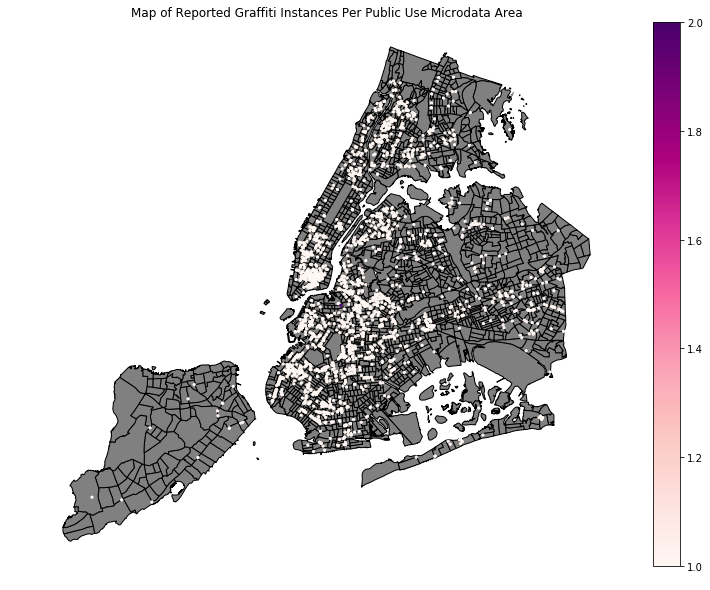

In [16]:
# mapping graffiti and puma 
f, ax = plt.subplots(figsize=(13,10))
ct.plot(ax = ax ,color = 'grey',edgecolor = 'black')
graffiti_geodf.plot(ax=ax, marker="o", markersize = 5, cmap='RdPu', column = 'count', legend = True)
ax.set_title("Map of Reported Graffiti Instances Per Public Use Microdata Area")

# Remove axis frames
ax.set_axis_off()

plt.savefig('Map_Graffiti_Instances.png')

#### Map of Graffiti Incidences from 2017 and 2018